# $$ Assignment 3 Machine Learning $$


> ## <span style="color:green">Load Data</span>

In [248]:
# Load data

import time
# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [249]:
links = pd.read_csv("C:/Users/Aakash Sharma/Desktop/Machine_Learning/Assignment3/Assignment3/MovieRating/ml-latest-small/links.csv")
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [250]:
links.shape

(9742, 3)

In [251]:
links['tmdbId'].isnull().value_counts()

False    9734
True        8
Name: tmdbId, dtype: int64

In [252]:
movies = pd.read_csv("C:/Users/Aakash Sharma/Desktop/Machine_Learning/Assignment3/Assignment3/MovieRating/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [253]:
movies.shape

(9742, 3)

In [254]:
ratings = pd.read_csv("C:/Users/Aakash Sharma/Desktop/Machine_Learning/Assignment3/Assignment3/MovieRating/ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [255]:
ratings.shape

(100836, 4)

In [448]:
Avg_user_rating=ratings.groupby("movieId")['rating'].mean().reset_index()
Avg_user_rating.rename(columns = {"rating":"Avg_Rating"}, 
                                 inplace = True)
Avg_user_rating.shape

(9724, 2)

In [256]:
tags = pd.read_csv("C:/Users/Aakash Sharma/Desktop/Machine_Learning/Assignment3/Assignment3/MovieRating/ml-latest-small/tags.csv")
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [257]:
tags.shape

(3683, 4)

In [258]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


> ## <span style="color:green">Exploratory data Analysis</span>

In [259]:
#1. Plot the counts of each rating
# get count
df_ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well



In [260]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551



The count for zero rating score is too big to compare with others. So let's take log transform for count values and then we can plot them to compare

In [261]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

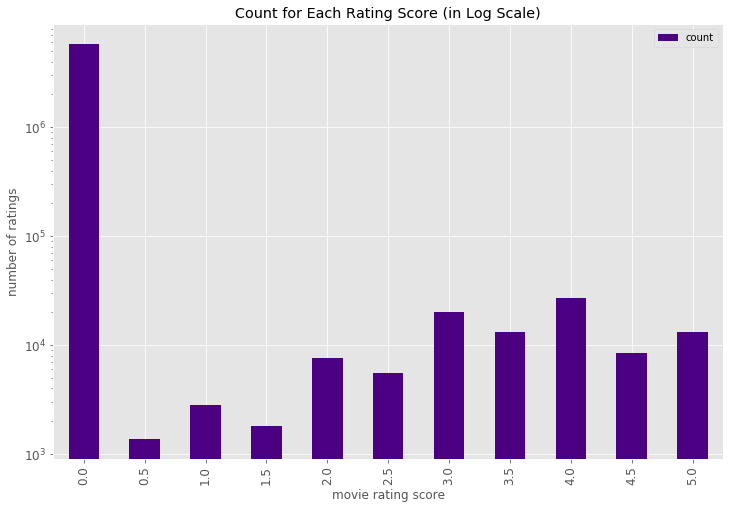

In [487]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
    color='indigo',
    
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores



In [263]:
#2. Plot rating frequency of all movies.
# get rating frequency
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

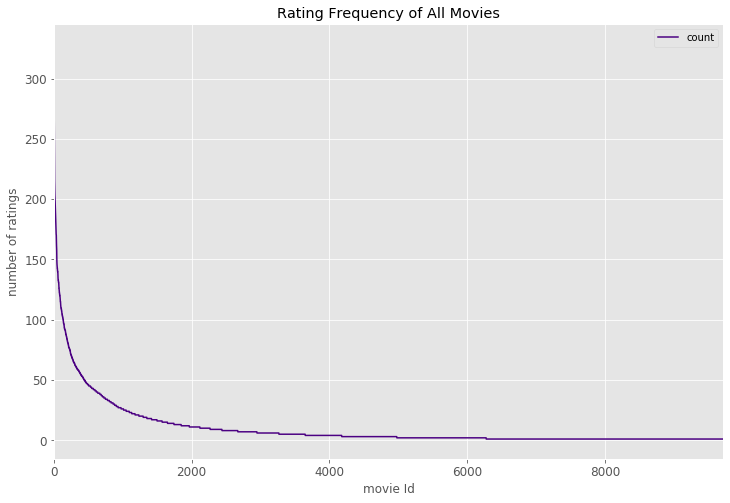

In [488]:

# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12,color='indigo'
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

Let's plot the same distribution but with log scale

Text(0, 0.5, 'number of ratings (log scale)')

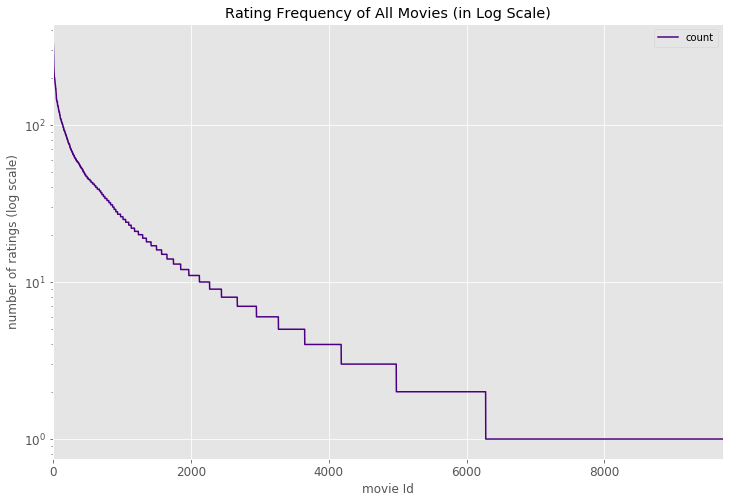

In [489]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True,color='indigo'
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")


We can see that roughly 10,000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [266]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))


1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64


So about 1% of movies have roughly 97,999 or more ratings, 5% have 1,855 or more, and 20% have 100 or more. Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.

- Memory issue: we don't want to run into the “MemoryError” during model training
- Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [267]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)


shape of original ratings data:  (100836, 4)
shape of ratings data after dropping unpopular movies:  (41360, 4)



After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [268]:

# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


Text(0, 0.5, 'number of ratings')

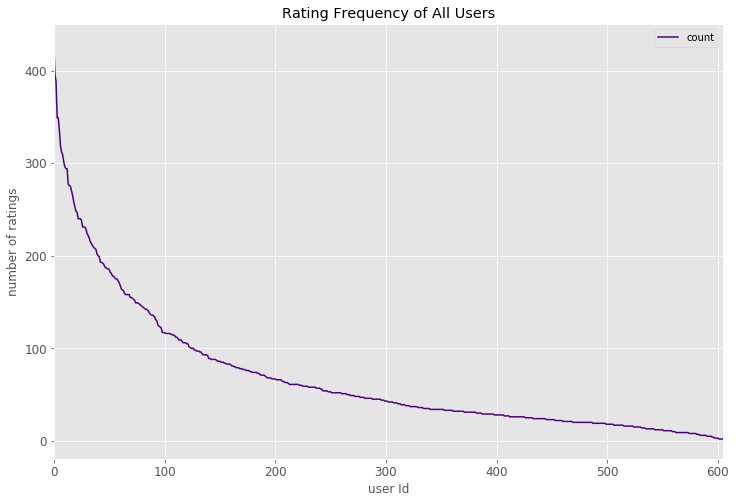

In [490]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12,color='indigo'
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [270]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))


1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64


We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 113,291 users.

In [271]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 4)


In [272]:
#3. Train KNN model for item-based collaborative filtering
#3.1. Reshaping the Data
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
movie_user_mat_sparse

<450x268 sparse matrix of type '<class 'numpy.float64'>'
	with 32999 stored elements in Compressed Sparse Row format>

For K-Nearest Neighbors, we want the data to be in an (artist, user) array, where each row is a movie and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [273]:
#3.2. Fitting the Model

%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

> ## <span style="color:green"> make some recommendations!</span>

In [274]:
# 4. Use this trained model to make movie recommendations to myself
# And we're finally ready to make some recommendations!

def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [324]:
my_favorite = input()

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

toy STORY
You have input movie: toy STORY
Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 3 (2010)', 'Toy Story 2 (1999)']

Recommendation system start to make inference
......

Recommendations for toy STORY:
1: Back to the Future (1985), with distance of 0.3423310709685232
2: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.3406687641315801
3: Apollo 13 (1995), with distance of 0.3377813877372813
4: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.3348625521441898
5: Shrek (2001), with distance of 0.3334433995717677
6: Pulp Fiction (1994), with distance of 0.33281778682539587
7: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 0.3267058482475984
8: Star Wars: Episode IV - A New Hope (1977), with distance of 0.32584484119025636
9: Forrest Gump (1994), with distance of 0.3068103361462835
10: Jurassic Park (1993), with distance of 0.2797789115289834


In [280]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 72.64% of ratings in our data is missing


## <span style="color:red">2. Display predicted rating for a particular userID and MovieID combinations (both taken as keyboard input)</span>

In [281]:
import pandas as pd
import numpy as np
from surprise import KNNWithMeans,KNNWithZScore
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [282]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [283]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [284]:
[trainset, testset] = train_test_split(data, test_size= .10, shuffle=True)

In [368]:
recom = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True})
recom.fit(data.build_full_trainset()) # using full training set and not doing k value
test_pred = recom.test(testset)
RMSE = accuracy.rmse(test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7737


In [359]:
user=int(input("Enter the UserId: "))
movie=int(input("Enter the MovieId: "))
pre = recom.predict(user,movie)
print('The rating value for item ' + str(movie) + ' by user ' + str(user) + ' is ', pre[3])

Enter the UserId: 65
Enter the MovieId: 432
The rating value for item 432 by user 65 is  3.2525433577909686


## <span style="color:red">3. Recommend a user to watch top 10 movies, which has not watched yet (as per his rating predictions). Take userID as a keyboard input. Fix the threshold rating as 2.5</span>

In [287]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix   # csr_matrix (compressed sparse row matrix)
from sklearn.neighbors import NearestNeighbors
import sklearn

In [407]:
merge_movie_links = links.merge(movies, on="movieId", how='left')
merge_movie_links.shape

(9742, 5)

In [409]:
merge_movie_links.head()

,movieId,imdbId,tmdbId,title,genres
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844.0,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602.0,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357.0,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862.0,Father of the Bride Part II (1995),Comedy


In [449]:
merge_ratings_Avg_user_rating = Avg_user_rating.merge(merge_movie_links, on="movieId", how='left')
merge_ratings_Avg_user_rating.head()

,movieId,Avg_Rating,imdbId,tmdbId,title,genres
0,1,3.920930,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.431818,113497,8844.0,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.259615,113228,15602.0,Grumpier Old Men (1995),Comedy|Romance
3,4,2.357143,114885,31357.0,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.071429,113041,11862.0,Father of the Bride Part II (1995),Comedy


In [453]:
from collections import Counter

userid=int(input("Enter the UserId: "))

def recommend(userid):
    movie_list={}
    
    # creating empty dictionary using userid as key and movieid as value
    for movieid in merge_ratings_Avg_user_rating['movieId']:
        if recom.predict(userid,movieid)[3] > 2.5:
            movie_list[movieid] = recom.predict(userid,movieid)[3]

    # Finding 10 highest values in the dictionary
    k = Counter(movie_list)
    high = k.most_common(10)

    print("Top 10 Movies for user ",userid,"are :")
    for i in range(10):
        print(i+1,"\t",list(movies[movies["movieId"]==high[i][0]]["title"])[0])
        
recommend(userid)

Enter the UserId: 54
Top 10 Movies for user  54 are :
1 	 The Big Bus (1976)
2 	 Jetée, La (1962)
3 	 Unfaithfully Yours (1948)
4 	 Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)
5 	 Seve (2014)
6 	 Villain (1971)
7 	 Paterson
8 	 Come and See (Idi i smotri) (1985)
9 	 On the Beach (1959)
10 	 Strictly Sexual (2008)


## <span style="color:red">4.	Display the MovieID, IMDB ID, Average User Rating (excluding predictions) and genres of all the movies found in Step 3 as a data frame.</span>

In [477]:
from collections import Counter

userid=int(input("Enter the UserId: "))

def recommend(userid):
    movie_list={}
    
    # creating empty dictionary using userid as key and movieid as value
    for movieid in merge_ratings_Avg_user_rating['movieId']:
        if recom.predict(userid,movieid)[3] > 2.5:
            movie_list[movieid] = recom.predict(userid,movieid)[3]

    # Finding 10 highest values in the dictionary
    k = Counter(movie_list)
    high = k.most_common(10)

    print("Top 10 Movies for user ",userid,"are :")

    
    # Making Data Frame
    
    df = pd.DataFrame(columns = ('Sr_No', 'Movie', 'Movie_ID', 'IMDB_ID','Avg_rating','Genre'))
    Sr_No = []
    Movie = []
    Movie_ID = []
    IMDB_ID = []
    Avg_rating = []
    Genre = []
    for i in range(10):

        Sr_No.append(i+1)
        Movie.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["title"])[0])   
        Movie_ID.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["movieId"])[0])
        IMDB_ID.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["imdbId"])[0])
        Avg_rating.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["Avg_Rating"])[0])
        Genre.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["genres"])[0])

    df['Sr_No']= Sr_No
    df['Movie'] = Movie
    df['Movie_ID'] = Movie_ID
    df['IMDB_ID'] = IMDB_ID
    df['Avg_rating'] = Avg_rating
    df['Genre'] = Genre
    return df
df1=recommend(userid)
df1

Enter the UserId: 3
Top 10 Movies for user  3 are :


,Sr_No,Movie,Movie_ID,IMDB_ID,Avg_rating,Genre
0,1,Galaxy of Terror (Quest) (1981),5746,82431,5.0,Action|Horror|Mystery|Sci-Fi
1,2,Alien Contamination (1980),6835,82000,5.0,Action|Horror|Sci-Fi
2,3,Bossa Nova (2000),3567,180837,5.0,Comedy|Drama|Romance
3,4,The Big Bus (1976),5490,74205,5.0,Action|Comedy
4,5,Seve (2014),132333,3149640,5.0,Documentary|Drama
5,6,Looker (1981),5764,82677,4.5,Drama|Horror|Sci-Fi|Thriller
6,7,Master of the Flying Guillotine (Du bi quan wa...,7899,72913,4.5,Action
7,8,Unfaithfully Yours (1948),25947,40919,5.0,Comedy
8,9,On the Beach (1959),3379,53137,4.5,Drama
9,10,Strictly Sexual (2008),67618,494277,5.0,Comedy|Drama|Romance


$$END$$